In [1]:
%cd ..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
# this just to make sure we are using only on CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
%load_ext autoreload
%autoreload 2
import copy
import time

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

# from learning_wavelets.data import im_generators, ConcatenateGenerators
from learning_wavelets.datasets import im_dataset_bsd68
from learning_wavelets.dncnn import dncnn
from learning_wavelets.keras_utils.thresholding import SoftThresholding, HardThresholding, DynamicSoftThresholding, DynamicHardThresholding, RelaxedDynamicHardThresholding, LocalWienerFiltering
from learning_wavelets.learned_wavelet import learned_wavelet, learnlet
from learning_wavelets.unet import unet
from learning_wavelets.utils.metrics import metrics_from_ds, metrics_original_from_ds
# from learning_wavelets.utils.metrics import metrics_for_params, metrics_exact_recon_net, metrics_original, metrics_wavelets, metrics_bm3d, metrics_dynamic_denoising_net


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.4.1     installed
numpy          : >=1.16.4  - required | 1.17.4    installed
matplotlib     : >=3.0.0   - required | 3.1.2     installed
astropy        : >=3.0.0   - required | 3.2.3     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [4]:
np.random.seed(0)

In [5]:
all_net_params = [
    {
        'name': 'unet-multiple-stds',
        'init_function': unet,
        'run_params': {
            'n_layers': 5, 
            'pool': 'max', 
            "layers_n_channels": [64, 128, 256, 512, 1024], 
            'layers_n_non_lins': 2,
            'non_relu_contract': False,
            'bn': True,
            'input_size': (None, None, 1),
        },
        'run_id': 'unet_dynamic_st_bsd500_0_55_1576668365',
        'epoch': 500,
    },
]

dynamic_denoising_net_params = [
    {
        'name': 'learnlet_0_55_big_bsd',
        'init_function': learnlet,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 256, 
                'mixing_details': False,  
                'kernel_size': 11
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'n_scales': 5,
            'exact_reconstruction_weight': 0,
            'clip': True,
            'input_size': (None, None, 1),     
        },
        'run_id': 'learnlet_dynamic_st_bsd500_0_55_1576762010',
        'epoch': 500,
    },
    {
        'name': 'learnlet_20_40_big_bsd',
        'init_function': learnlet,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 256, 
                'mixing_details': False,  
                'kernel_size': 11,
                'skip_connection': True,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'n_scales': 5,
            'exact_reconstruction_weight': 0,
            'clip': True,
            'input_size': (None, None, 1),     
        },
        'run_id': 'learnlet_dynamic_st_bsd500_20_40_1580492805',
        'epoch': 500,
    },
    {
        'name': 'learnlet_30_big_bsd',
        'init_function': learnlet,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 256, 
                'mixing_details': False,  
                'kernel_size': 11,
                'skip_connection': True,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'n_scales': 5,
            'exact_reconstruction_weight': 0,
            'clip': True,
            'input_size': (None, None, 1),     
        },
        'run_id': 'learnlet_dynamic_st_bsd500_30_1580668579',
        'epoch': 500,
    },
]

In [6]:
noise_stds = [5, 15, 20, 25, 30, 50, 75]
# noise_stds = [15, 20, 30]
# noise_stds = [30]

In [7]:
noise_std_metrics = {}
n_samples = 5
for noise_std in tqdm_notebook(noise_stds, 'Noise stds'):
    metrics = []
    for net_params in all_net_params:
        im_ds = im_dataset_bsd68(
            mode='testing', 
            batch_size=1, 
            patch_size=None, 
            noise_std=noise_std, 
            return_noise_level=False,
            n_pooling=5,
            n_samples=n_samples,
        )
        metrics.append((net_params['name'], metrics_from_ds(im_ds, **net_params)))
    im_ds = im_dataset_bsd68(
        mode='testing', 
        batch_size=1, 
        patch_size=None, 
        noise_std=noise_std, 
        return_noise_level=False,
        n_pooling=5,
        n_samples=n_samples,
    )
    metrics.append(('original', metrics_original_from_ds(im_ds)))
        
    for net_params in dynamic_denoising_net_params:
        im_ds = im_dataset_bsd68(
            mode='testing', 
            batch_size=1, 
            patch_size=None, 
            noise_std=noise_std, 
            return_noise_level=True,
            n_pooling=5,
            n_samples=n_samples,
        )
        metrics.append((net_params['name'], metrics_from_ds(im_ds, **net_params)))

#     metrics.append(('bm3d', metrics_bm3d(im_gen_test)))
#     metrics.append(('wavelets_24', metrics_wavelets(im_gen_test, '24', noise_std=noise_std)))
#     metrics.sort(key=lambda x: x[1].metrics['PSNR'].mean())
    noise_std_metrics[noise_std] = metrics

/volatile/home/Zaccharie/workspace/understanding-unets/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/volatile/home/Zaccharie/workspace/understanding-unets/learning_wavelets/evaluate.py:29: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=1)
/volatile/home/Zaccharie/workspace/understanding-unets/learning_wavelets/evaluate.py:38: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  gt, pred, multichannel=True, data_range=1


In [8]:
noise_std_metrics

{5: [('unet-multiple-stds', PSNR = 38.2 +/- 3.735 SSIM = 0.9686 +/- 0.01937),
  ('original', PSNR = 34.16 +/- 0.03369 SSIM = 0.8695 +/- 0.1112),
  ('learnlet_0_55_big_bsd', PSNR = 37.14 +/- 4.133 SSIM = 0.9623 +/- 0.02299),
  ('learnlet_20_40_big_bsd', PSNR = 32.72 +/- 7.983 SSIM = 0.9484 +/- 0.0376),
  ('learnlet_30_big_bsd', PSNR = 31.65 +/- 8.439 SSIM = 0.9422 +/- 0.04554)],
 15: [('unet-multiple-stds', PSNR = 32.11 +/- 4.444 SSIM = 0.8951 +/- 0.07118),
  ('original', PSNR = 24.62 +/- 0.0149 SSIM = 0.5306 +/- 0.2514),
  ('learnlet_0_55_big_bsd', PSNR = 31.47 +/- 4.477 SSIM = 0.874 +/- 0.07115),
  ('learnlet_20_40_big_bsd', PSNR = 31.29 +/- 4.91 SSIM = 0.8745 +/- 0.06967),
  ('learnlet_30_big_bsd', PSNR = 31.2 +/- 5.107 SSIM = 0.875 +/- 0.06728)],
 20: [('unet-multiple-stds', PSNR = 30.73 +/- 4.651 SSIM = 0.8626 +/- 0.0949),
  ('original', PSNR = 22.11 +/- 0.02487 SSIM = 0.4282 +/- 0.2489),
  ('learnlet_0_55_big_bsd', PSNR = 30.08 +/- 4.582 SSIM = 0.8342 +/- 0.08794),
  ('learnlet_20

In [108]:
BM3D_psnr_results = {
    5: 37.57,
    15: 31.07,
    20: 29.60,
    25: 28.57,
    30: 27.74,
    50: 25.62,
    75: 24.21,
}

wavelets_psnr_results = {
    5: (35.76,  1.937),
    15: (29.56,  2.553),
    20: (28.25,  2.645),
    25: (27.32,  2.684),
    30: (26.61,  2.694),
    50: (24.79,  2.673),
    75: (23.46,  2.574),
}

In [109]:
# PSNR table
psnr_metrics_table = pd.DataFrame(
    columns=['noise_std'] + [p['name'] for p in all_net_params] + [p['name'] for p in dynamic_denoising_net_params] + ['original', 'wavelets_24', 'bm3d'],
)
for i, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    psnr_metrics_table.loc[i, 'noise_std'] = noise_std
    for name, m in metrics:
        psnr_metrics_table.loc[i, name] = "{mean:.4} ({std:.4})".format(
            mean=m.metrics['PSNR'].mean(), 
            std=m.metrics['PSNR'].stddev(),
        )
    psnr_metrics_table.loc[i, 'bm3d'] = BM3D_psnr_results[noise_std]
    psnr_metrics_table.loc[i, 'wavelets_24'] = "{mean:.4} ({std:.4})".format(
        mean=wavelets_psnr_results[noise_std][0], 
        std=wavelets_psnr_results[noise_std][1],
    )
psnr_metrics_table

,noise_std,unet-multiple-stds,learnlet_0_55_big_bsd,learnlet_20_40_big_bsd,learnlet_30_big_bsd,original,wavelets_24,bm3d
0,5,38.2 (1.868),37.14 (2.066),32.72 (3.992),31.65 (4.219),34.16 (0.01685),35.76 (1.937),37.57
1,15,32.11 (2.222),31.47 (2.238),31.29 (2.455),31.2 (2.553),24.62 (0.007451),29.56 (2.553),31.07
2,20,30.73 (2.325),30.08 (2.291),30.09 (2.348),30.02 (2.394),22.11 (0.01243),28.25 (2.645),29.6
3,25,29.67 (2.415),29.01 (2.325),29.1 (2.314),29.05 (2.275),20.16 (0.02027),27.32 (2.684),28.57
4,30,28.87 (2.475),28.19 (2.314),28.25 (2.279),28.22 (2.252),18.58 (0.01571),26.61 (2.694),27.74
5,50,26.72 (2.582),25.92 (2.316),25.86 (2.171),25.86 (2.178),14.15 (0.01382),24.79 (2.673),25.62
6,75,22.45 (1.265),24.1 (2.146),24.0 (1.978),23.98 (2.033),10.63 (0.01462),23.46 (2.574),24.21


In [110]:
# SSIM table
ssim_metrics_table = pd.DataFrame(
    columns=['noise_std'] + [p['name'] for p in all_net_params] + [p['name'] for p in dynamic_denoising_net_params] + ['original', 'wavelets_24', 'bm3d'],
)
for i, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    ssim_metrics_table.loc[i, 'noise_std'] = noise_std
    for name, m in metrics:
        ssim_metrics_table.loc[i, name] = "{mean:.4} ({std:.4})".format(
            mean=m.metrics['SSIM'].mean(), 
            std=m.metrics['SSIM'].stddev(),
        )
ssim_metrics_table

,noise_std,unet-multiple-stds,learnlet_0_55_big_bsd,learnlet_20_40_big_bsd,learnlet_30_big_bsd,original,wavelets_24,bm3d
0,5,0.9686 (0.009685),0.9623 (0.01149),0.9484 (0.0188),0.9422 (0.02277),0.8695 (0.05562),NaN,NaN
1,15,0.8951 (0.03559),0.874 (0.03558),0.8745 (0.03484),0.875 (0.03364),0.5306 (0.1257),NaN,NaN
2,20,0.8626 (0.04745),0.8342 (0.04397),0.8339 (0.0416),0.833 (0.04221),0.4282 (0.1244),NaN,NaN
3,25,0.8319 (0.05893),0.7946 (0.05068),0.7968 (0.04468),0.7945 (0.04371),0.3531 (0.1172),NaN,NaN
4,30,0.805 (0.06688),0.7624 (0.05291),0.7596 (0.04573),0.7579 (0.0462),0.2955 (0.1074),NaN,NaN
5,50,0.719 (0.09581),0.64 (0.05528),0.6321 (0.04944),0.6303 (0.04645),0.1624 (0.07342),NaN,NaN
6,75,0.384 (0.04175),0.5219 (0.05128),0.5102 (0.034),0.505 (0.03551),0.08869 (0.04695),NaN,NaN


In [111]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
sns.set(style="whitegrid", palette="muted", rc={'figure.figsize': (9, 5), 'image.cmap': 'gray'})

In [113]:
model_family_str = r'Model'
train_stds_str = r'Train standard deviation'
noise_std_str = 'Test noise standard deviation'
psnr_str = 'PSNR'
# PSNR to plot
psnr_to_plot = pd.DataFrame(
    columns=[noise_std_str, psnr_str, 'psnr-std-dev', 'model_name', model_family_str, train_stds_str]
)

def from_name_to_family(model_name):
    if 'learnlet' in model_name:
        return 'Learnlets'
    elif 'unet' in model_name:
        return 'U-net'
    elif 'bm3d' in model_name:
        return 'BM3D'
    elif 'wavelets' in model_name:
        return 'Wavelets'
    else:
        return 'Original'
    
def from_name_to_train_stds(model_name):
    if '30' in model_name:
        return '30'
    elif '20_40' in model_name:
        return '[20; 40]'
    else:
        return '[0; 55]'

family_model_to_color = {
    'U-net': (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
    'Learnlets': (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
    'BM3D': 'violet',
    'Wavelets': 'red',
    'Original': (0.41568627450980394, 0.8, 0.39215686274509803),
}
index = 0
for i_noise, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    for j_model, (name, m) in enumerate(metrics):
        psnr_to_plot.loc[index, noise_std_str] = noise_std
        psnr_to_plot.loc[index, psnr_str] = m.metrics['PSNR'].mean()
        psnr_to_plot.loc[index, 'psnr-std-dev'] = m.metrics['PSNR'].stddev() / 2
        psnr_to_plot.loc[index, 'model_name'] = name
        psnr_to_plot.loc[index, train_stds_str] = from_name_to_train_stds(name)
        psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name)
        index += 1
    name = 'bm3d'
    psnr_to_plot.loc[index, noise_std_str] = noise_std
    psnr_to_plot.loc[index, psnr_str] = BM3D_psnr_results[noise_std]
    psnr_to_plot.loc[index, 'psnr-std-dev'] = 0
    psnr_to_plot.loc[index, 'model_name'] = name
    psnr_to_plot.loc[index, train_stds_str] = from_name_to_train_stds(name)
    psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name)
    index += 1
    name = 'wavelets_24'
    psnr_to_plot.loc[index, noise_std_str] = noise_std
    psnr_to_plot.loc[index, psnr_str] = wavelets_psnr_results[noise_std][0]
    psnr_to_plot.loc[index, 'psnr-std-dev'] = wavelets_psnr_results[noise_std][1]
    psnr_to_plot.loc[index, 'model_name'] = name
    psnr_to_plot.loc[index, train_stds_str] = from_name_to_train_stds(name)
    psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name)
    index += 1
psnr_to_plot

,Test noise standard deviation,PSNR,psnr-std-dev,model_name,Model,Train standard deviation
0,5,38.2039,0.933777,unet-multiple-stds,U-net,[0; 55]
1,5,34.1559,0.00842284,original,Original,[0; 55]
2,5,37.1366,1.03321,learnlet_0_55_big_bsd,Learnlets,[0; 55]
3,5,32.7176,1.99581,learnlet_20_40_big_bsd,Learnlets,[20; 40]
4,5,31.6496,2.10965,learnlet_30_big_bsd,Learnlets,30
5,5,37.57,0,bm3d,BM3D,[0; 55]
6,5,35.76,1.937,wavelets_24,Wavelets,[0; 55]
7,15,32.1133,1.11093,unet-multiple-stds,U-net,[0; 55]
8,15,24.6155,0.00372558,original,Original,[0; 55]
9,15,31.4667,1.11922,learnlet_0_55_big_bsd,Learnlets,[0; 55]


<IPython.core.display.Javascript object>


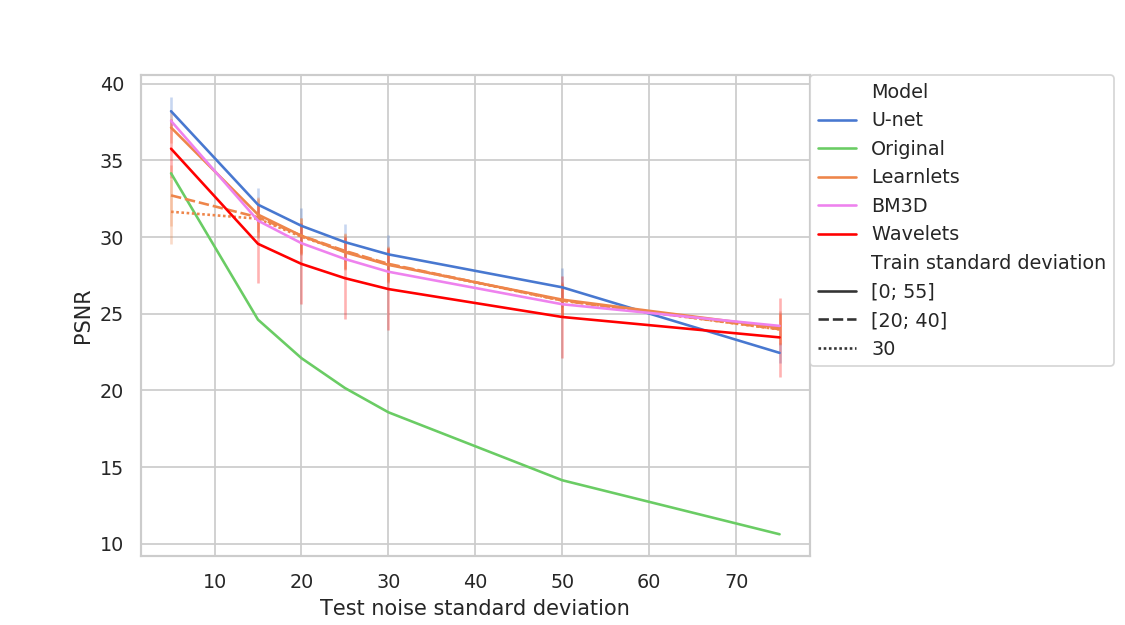

In [114]:
psnr_to_plot[psnr_str] = psnr_to_plot[psnr_str].astype(float)
lplot = sns.lineplot(
    x=noise_std_str, 
    y=psnr_str, 
    hue=model_family_str,
    style=train_stds_str,
    data=psnr_to_plot,
    palette=family_model_to_color,
)
lplot.errorbar(
    x=noise_std_str, 
    y=psnr_str,
    yerr='psnr-std-dev',
    fmt='none',
    ecolor=[family_model_to_color[mf] for mf in psnr_to_plot[model_family_str]],
    data=psnr_to_plot,
    alpha=0.3,
    label=None,
)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best', borderaxespad=0)
plt.subplots_adjust(right=0.72)

In [106]:
l = lplot.legend()
?l

In [107]:
l.title

AttributeError: 'Legend' object has no attribute 'title'